In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy

In [2]:
I = cv2.imread('pedestrians/pos/per00060.ppm', cv2.IMREAD_GRAYSCALE)

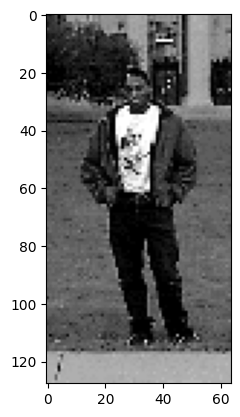

In [3]:
plt.imshow(I, 'gray')

In [4]:
def calculate_gradients(img):  
    dx = scipy.ndimage.convolve1d(np.int32(img), np.array([-1, 0, 1]),1) 
    dy = scipy.ndimage.convolve1d(np.int32(img), np.array([-1, 0, 1]),0)
    
    magnitude = np.sqrt(dx**2 + dy**2)
    argmax_magnitude = None
    if len(magnitude.shape) == 3:
        argmax_magnitude = np.argmax(magnitude, axis=2)
        magnitude = np.max(magnitude, axis=2)
        
    angle = np.arctan2(dy, dx)
    if len(angle.shape) == 3:
        angle = angle[:,:,argmax_magnitude]
        
    return magnitude, angle

In [5]:
def create_histogram(magnitude, angle, cell_size=8, bin_size=20):
    bins = int(180 / bin_size)
    histogram = np.zeros((int(magnitude.shape[0]/cell_size), int(magnitude.shape[1]/cell_size), bins))
    
    for i in range(0, magnitude.shape[0], cell_size):
        for j in range(0, magnitude.shape[1], cell_size):
            for x in range(i, i+cell_size):
                for y in range(j, j+cell_size):
                    if angle[x, y] < 0:
                        angle[x, y] += np.pi
                    degree = np.rad2deg(angle[x, y])
                    
                    bin_index = int((degree % 180) / bin_size)
                    bin_center = bin_index * bin_size + bin_size / 2
                    if degree < bin_center:
                        lower_bin_index = ((bin_index - 1) + bins) % bins
                        upper_bin_index = bin_index
                    else:
                        lower_bin_index = bin_index
                        upper_bin_index = (bin_index + 1) % bins
                    lower_bin_fi = degree - (lower_bin_index * bin_size + bin_size / 2)
                    upper_bin_fi = (upper_bin_index * bin_size + bin_size / 2) - degree
                    
                    if lower_bin_fi < 0:
                        lower_bin_fi += 180
                    if upper_bin_fi < 0:
                        upper_bin_fi += 180
                        
                    upper_bin_weight = lower_bin_fi / bin_size
                    lower_bin_weight = upper_bin_fi / bin_size
                    
                    histogram[int(i/cell_size), int(j/cell_size), lower_bin_index] += magnitude[x, y] * lower_bin_weight
                    histogram[int(i/cell_size), int(j/cell_size), upper_bin_index] += magnitude[x, y] * upper_bin_weight
    return histogram

In [6]:
import math
def normalize_histogram(hist, XX_cell, YY_cell):
    e = math.pow(0.00001,2) 
    F = []
    
    for jj in range(0, YY_cell - 1):
        for ii in range(0, XX_cell - 1):
            H0 = hist[jj,ii,:] 
            H1 = hist[jj,ii+1,:]
            H2 = hist[jj+1,ii,:]
            H3 = hist[jj+1,ii+1,:]
            H = np.concatenate((H0, H1, H2, H3)) 
            n = np.linalg.norm(H)
            Hn = H/np.sqrt(math.pow(n,2)+e) 
            F = np.concatenate((F,Hn))
    
    return F

In [7]:
magnitude, angle = calculate_gradients(I)

In [8]:
histogram = create_histogram(magnitude, angle)

In [9]:
histogram[0,0,:]

array([ 769.79561541, 1411.33722077,   97.81589877,  234.04630571,
        284.85629728,  238.29421276,  112.13474548,  272.30912315,
        233.71648346])

In [10]:
normalized_histogram = normalize_histogram(histogram, histogram.shape[1], histogram.shape[0])

In [11]:
normalized_histogram.shape

(3780,)

In [12]:
def HOGpicture(w, bs): # w - histograms, bs - cell size (8) 
    bim1 = np.zeros((bs, bs)) 
    bim1[np.round(bs//2):np.round(bs//2)+1,:] = 1
    bim = np.zeros(bim1.shape+(9,))
    bim[:,:,0] = bim1
    for i in range(2,9): #2:9,
        bim[:,:,i] = scipy.ndimage.rotate(bim1, -i*20) / 255
        
    Y,X,Z = w.shape
    w[w < 0] = 0
    im = np.zeros((bs*Y, bs*X))
    
    for i in range(Y): 
        iisl = i*bs
        iisu = (i+1)*bs 
        for j in range(X):
            jjsl = j*bs 
            jjsu=(j+1)*bs
            for k in range(9):
                im[iisl:iisu,jjsl:jjsu] += bim[:,:,k] * w[i,j,k]
            
    return im

In [13]:
# hog_image = HOGpicture(histogram, 8)
# plt.imshow(hog_image, 'gray')

In [14]:
def hog(img):
    magnitude, angle = calculate_gradients(img)
    histogram = create_histogram(magnitude, angle)
    normalized_histogram = normalize_histogram(histogram, histogram.shape[1], histogram.shape[0])
    return normalized_histogram

In [15]:

HOG_data = np.zeros([2*924,3781],np.float32)

for i in range(0,924):
    IP = cv2.imread('pedestrians/pos/per%05d.ppm' % (i+1), cv2.IMREAD_GRAYSCALE) 
    IN = cv2.imread('pedestrians/neg/neg%05d.png' % (i+1), cv2.IMREAD_GRAYSCALE) 
    F = hog(IP)
    HOG_data[i,0] = 1
    HOG_data[i,1:] = F
    F = hog(IN)
    HOG_data[i+924,0] = 0
    HOG_data[i+924,1:] = F

In [16]:
from sklearn.model_selection import train_test_split

labels = HOG_data[:,0]
data = HOG_data [: ,1:]
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

In [17]:
from sklearn import svm

clf = svm.SVC(kernel='linear', C=5.0)
clf.fit(X_train, y_train)

SVC(C=5.0, kernel='linear')

In [30]:
lp = clf.predict(X_train)
print('Train Accuracy:', np.mean(lp == y_train))

Train Accuracy: 1.0


In [19]:
# Confusion matrix
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train, lp)

array([[746,   0],
       [  0, 732]])

In [31]:
lp_test = clf.predict(X_test)
print('Test Accuracy:', np.mean(lp_test == y_test))

Test Accuracy: 1.0


In [21]:
confusion_matrix(y_test, lp_test)

array([[178,   0],
       [  0, 192]])

### Zadanie 3

In [22]:
height = 128
length = 64

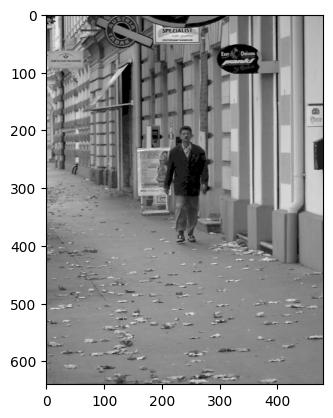

In [24]:
I_test = cv2.imread('test_pedestrians/testImage2.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(I_test, 'gray')

In [82]:
I_test = cv2.imread('test_pedestrians/testImage2.png', cv2.IMREAD_GRAYSCALE)
I_test = cv2.resize(I_test, (int(I_test.shape[1] * 0.5), int(I_test.shape[0] * 0.5)))

result_images = {}
best_score = 0

for y in range(0, I_test.shape[0] - height, 8):
    for x in range(0, I_test.shape[1] - length, 8):
        hog_img = hog(I_test[y:y+height, x:x+length])
        score = clf.decision_function(hog_img.reshape(1, -1))
        if clf.predict(hog_img.reshape(1, -1)) == 1:
            if score > best_score:
                best_score = score
            I_rect = I_test.copy()
            I_rect = cv2.rectangle(I_rect, (x, y), (x+length, y+height), (255, 0, 0), 1)
            result_images[score[0]] = I_rect

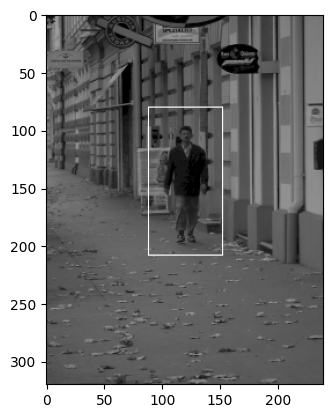

In [86]:
plt.imshow(result_images[best_score[0]], 'gray')

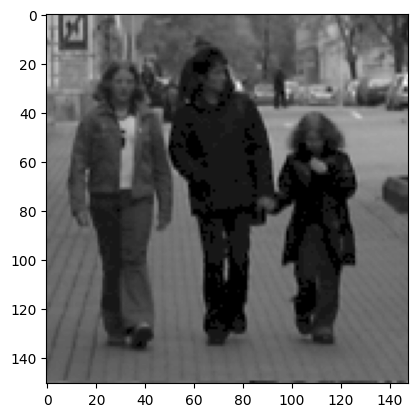

In [28]:
I_test = cv2.imread('test_pedestrians/testImage3.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(I_test, 'gray')

In [60]:
I_test = cv2.imread('test_pedestrians/testImage3.png', cv2.IMREAD_GRAYSCALE)
I_rect = I_test.copy()

for y in range(0, I_test.shape[0] - height, 8):
    for x in range(0, I_test.shape[1] - length, 8):
        hog_img = hog(I_test[y:y+height, x:x+length])
        if clf.predict(hog_img.reshape(1, -1)) == 1:
            I_rect = cv2.rectangle(I_rect, (x, y), (x+length, y+height), (255, 0, 0), 1)

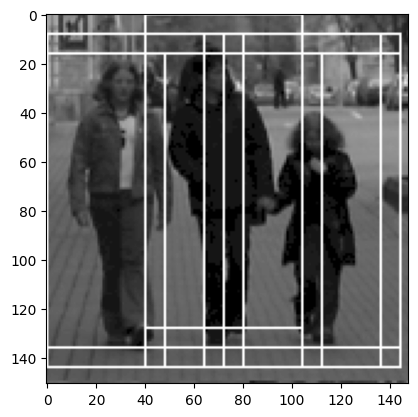

In [61]:
plt.imshow(I_rect, 'gray')

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


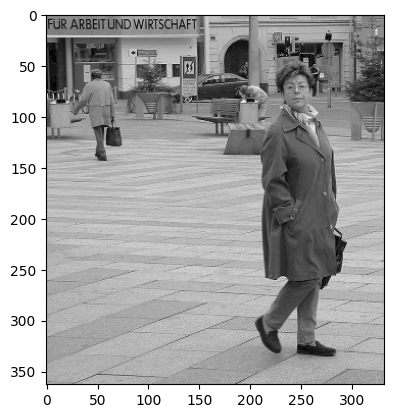

In [34]:
I_test = cv2.imread('test_pedestrians/testImage4.png', cv2.IMREAD_GRAYSCALE)
plt.imshow(I_test, 'gray')

In [96]:
I_test = cv2.imread('test_pedestrians/testImage4.png', cv2.IMREAD_GRAYSCALE)
result_images = {}
best_score = 0

for y in range(0, I_test.shape[0] - height, 8):
    for x in range(0, I_test.shape[1] - length, 8):
        hog_img = hog(I_test[y:y+height, x:x+length])
        score = clf.decision_function(hog_img.reshape(1, -1))
        if clf.predict(hog_img.reshape(1, -1)) == 1:
            if score > best_score:
                best_score = score
                print(score)
            I_rect = I_test.copy()
            I_rect = cv2.rectangle(I_rect, (x, y), (x+length, y+height), (255, 0, 0), 1)
            result_images[score[0]] = I_rect

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


[0.12011403]
[0.42699445]
[0.67060611]


In [ ]:
print(result_images.keys())

In [97]:
plt.imshow(result_images[], 'gray')

KeyError: 0.42699445

In [90]:
I_test = cv2.imread('test_pedestrians/testImage4.png', cv2.IMREAD_GRAYSCALE)
I_test = cv2.resize(I_test, (int(I_test.shape[1] * 0.4), int(I_test.shape[0] * 0.4)))
result_images = {}
best_score = 0

for y in range(0, I_test.shape[0] - height, 8):
    for x in range(0, I_test.shape[1] - length, 8):
        hog_img = hog(I_test[y:y+height, x:x+length])
        score = clf.decision_function(hog_img.reshape(1, -1))
        if clf.predict(hog_img.reshape(1, -1)) == 1:
            if score > best_score:
                best_score = score
            I_rect = I_test.copy()
            I_rect = cv2.rectangle(I_rect, (x, y), (x+length, y+height), (255, 0, 0), 1)
            result_images[score[0]] = I_rect

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: cHRM chunk does not match sRGB


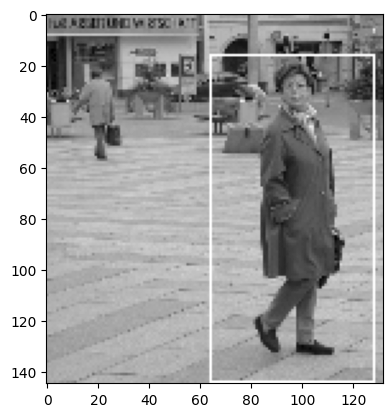

In [91]:
plt.imshow(result_images[best_score[0]], 'gray')